In [5]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch
from torch.utils.data import Subset

import medmnist
from medmnist import INFO, Evaluator

# We first work on a 2D dataset with size 28x28

In [6]:
# data_flag = 'pneumoniamnist'
data_flag = 'chestmnist'
download = True

NUM_EPOCHS = 10
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [7]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
train_subset = Subset(train_dataset, indices=list(range(1280)))

# Dividir el conjunto de entrenamiento en entrenamiento y validación
train_size = int(0.8 * len(train_subset))
valid_size = len(train_subset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(train_subset, [train_size, valid_size])

test_dataset = DataClass(split='test', transform=data_transform, download=download)
test_subset = Subset(test_dataset, indices=list(range(320)))

# Preprocesamiento para las imágenes volteadas
flipped_transform = transforms.Compose([
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset_flipped = DataClass(split='train', transform=flipped_transform, download=download)

# Combinar los dos conjuntos de train
combined_dataset  = data.ConcatDataset([train_dataset, train_dataset_flipped])
combined_subset = Subset(combined_dataset, indices=list(range(1280)))

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=combined_subset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = data.DataLoader(dataset=valid_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_subset, batch_size=BATCH_SIZE, shuffle=False)


Using downloaded and verified file: /Users/cmoro/.medmnist/chestmnist.npz
Using downloaded and verified file: /Users/cmoro/.medmnist/chestmnist.npz
Using downloaded and verified file: /Users/cmoro/.medmnist/chestmnist.npz


In [8]:
# Visualizar las imágenes
# train_dataset.montage(length=20)

In [9]:

# train_dataset_flipped.montage(length=20)

## Then, we define a simple model for illustration, object function and optimizer that we use to classify.

In [10]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)
    
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

## Then, we define a simple model for illustration, object function and optimizer that we use to classify.

## Next, we can start to train and evaluate!

In [14]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = valid_loader if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))


100%|██████████| 1/1 [00:00<00:00, 14.55it/s]


[0.6589188635349273, 0.6352104246616364, 0.5999121129512787, 0.5573426783084869, 0.5065578818321228, 0.44862808883190153, 0.3865265786647797, 0.3275989830493927, 0.27765415906906127, 0.24092864543199538]


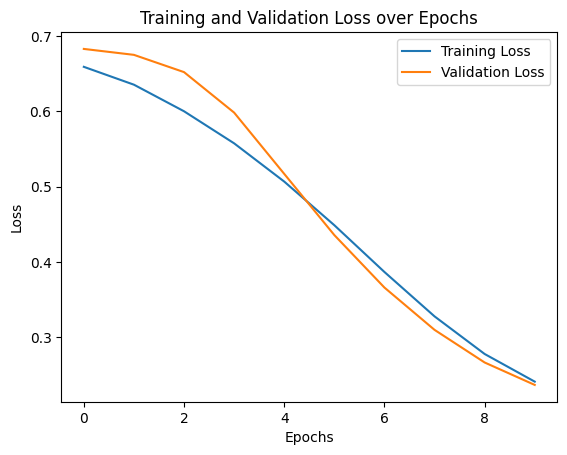

In [12]:
import matplotlib.pyplot as plt

# Listas para almacenar los valores de pérdida en cada epoch
train_loss_values = []
val_loss_values = []

# Train
for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    epoch_train_loss = 0.0  # Inicializar la pérdida de entrenamiento para esta época
    for inputs, targets in tqdm(train_loader):
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()  # Sumar la pérdida en cada iteración de entrenamiento

    # Calcular el promedio de pérdida para esta época de entrenamiento
    epoch_train_loss /= len(train_loader)
    train_loss_values.append(epoch_train_loss)  # Agregar el valor promedio de pérdida a la lista de pérdidas de entrenamiento

    # Validation
    model.eval()
    epoch_val_loss = 0.0  # Inicializar la pérdida de validación para esta época
    with torch.no_grad():
        for inputs, targets in tqdm(valid_loader):
            outputs = model(inputs)
            
            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                loss = criterion(outputs, targets)
            else:
                targets = targets.squeeze().long()
                loss = criterion(outputs, targets)
            
            epoch_val_loss += loss.item()  # Sumar la pérdida en cada iteración de validación
        
        epoch_val_loss /= len(valid_loader)  # Calcular el promedio de pérdida para esta época de validación
        val_loss_values.append(epoch_val_loss)  # Agregar el valor promedio de pérdida a la lista de pérdidas de validación

# Trazar los valores de pérdida
print(train_loss_values)
plt.plot(train_loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
        
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...


AssertionError: 